#### Taylor For Week #9

* 7 New emotions added. MLP: 40% RF: 89%

In [21]:
# Imports
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Spotify authentication
client_credentials = SpotifyClientCredentials(client_id='97a92c7614f248d38952612def032c31', 
                                              client_secret='51f8eaebb63042678edbaf3d3a52f82c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials)

In [10]:
# Function to get track features from Spotify
def get_track_features(track_id):
    features = sp.audio_features([track_id])[0]
    if features is not None:
        # Features added
        return [features['danceability'], features['energy'], features['valence'], 
                features['acousticness'], features['tempo'], features['speechiness'], features['liveness']]
    return None

# Get track IDs for a specific mood
def get_tracks_for_mood(mood, limit=50):
    results = sp.search(q=mood, type='track', limit=limit)
    return [track['id'] for track in results['tracks']['items']]

In [11]:
# Updated additional moods
moods = ['happy', 'sad', 'relaxed', 'energetic', 'calm', 'angry', 'excited', 
         'focused', 'nostalgic', 'cheerful', 'sleepy']

# Fetch features for each mood
X = []
y = []

In [12]:
for mood in moods:
    # WHile this is good for testing, we will eventually need to output this to file
    print(f"Fetching tracks for mood: {mood}")
    track_ids = get_tracks_for_mood(mood)
    for track_id in track_ids:
        features = get_track_features(track_id)
        if features:
            X.append(features)
            y.append(mood)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode target labels to numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Data augmentation function
def augment_data(X, y, n_augment=2):
    X_augmented = []
    y_augmented = []
    for i in range(len(X)):
        for _ in range(n_augment):
            noise = np.random.normal(0, 0.01, X[i].shape)
            X_augmented.append(X[i] + noise)
            y_augmented.append(y[i])
    return np.array(X_augmented), np.array(y_augmented)

# Apply data augmentation
X_augmented, y_augmented = augment_data(X_scaled, y_encoded)
X_combined = np.vstack((X_scaled, X_augmented))
y_combined = np.concatenate((y_encoded, y_augmented))

# Split the augmented data
X_temp, X_test, y_temp, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

Fetching tracks for mood: happy
Fetching tracks for mood: sad
Fetching tracks for mood: relaxed
Fetching tracks for mood: energetic
Fetching tracks for mood: calm
Fetching tracks for mood: angry
Fetching tracks for mood: excited
Fetching tracks for mood: focused
Fetching tracks for mood: nostalgic
Fetching tracks for mood: cheerful
Fetching tracks for mood: sleepy


In [13]:
# Define MLPClassifier with early stopping
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16), max_iter=2000, alpha=0.01, 
    learning_rate_init=0.001, random_state=42
)

In [14]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 20
patience_counter = 0

for epoch in range(2000):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_encoded))
    train_loss = mlp.loss_
    val_loss = 1 - accuracy_score(y_val, mlp.predict(X_val))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 0, Train Loss: 2.4466, Val Loss: 0.8994
Early stopping triggered.


In [15]:

# Evaluate MLP on test set

y_pred_mlp = mlp.predict(X_test)
test_accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Test Accuracy: {test_accuracy_mlp:.4f}")
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp, target_names=le.classes_))


MLP Test Accuracy: 0.3415
MLP Classification Report:
               precision    recall  f1-score   support

       angry       0.21      0.28      0.24        29
        calm       0.38      0.58      0.46        26
    cheerful       0.41      0.27      0.33        26
   energetic       0.17      0.15      0.16        27
     excited       0.39      0.44      0.42        34
     focused       0.50      0.23      0.32        30
       happy       0.24      0.17      0.20        35
   nostalgic       0.30      0.17      0.21        36
     relaxed       0.50      0.48      0.49        29
         sad       0.30      0.62      0.41        32
      sleepy       0.53      0.42      0.47        24

    accuracy                           0.34       328
   macro avg       0.36      0.35      0.34       328
weighted avg       0.35      0.34      0.33       328



In [16]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=42)

In [17]:
# Evaluate Random Forest
y_pred_rf = rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Test Accuracy: 0.8933
Random Forest Classification Report:
               precision    recall  f1-score   support

       angry       0.93      0.93      0.93        29
        calm       1.00      1.00      1.00        26
    cheerful       0.88      0.85      0.86        26
   energetic       0.82      0.85      0.84        27
     excited       0.96      0.79      0.87        34
     focused       0.83      1.00      0.91        30
       happy       0.86      0.86      0.86        35
   nostalgic       0.97      0.83      0.90        36
     relaxed       0.93      0.93      0.93        29
         sad       0.78      0.91      0.84        32
      sleepy       0.92      0.92      0.92        24

    accuracy                           0.89       328
   macro avg       0.90      0.90      0.90       328
weighted avg       0.90      0.89      0.89       328



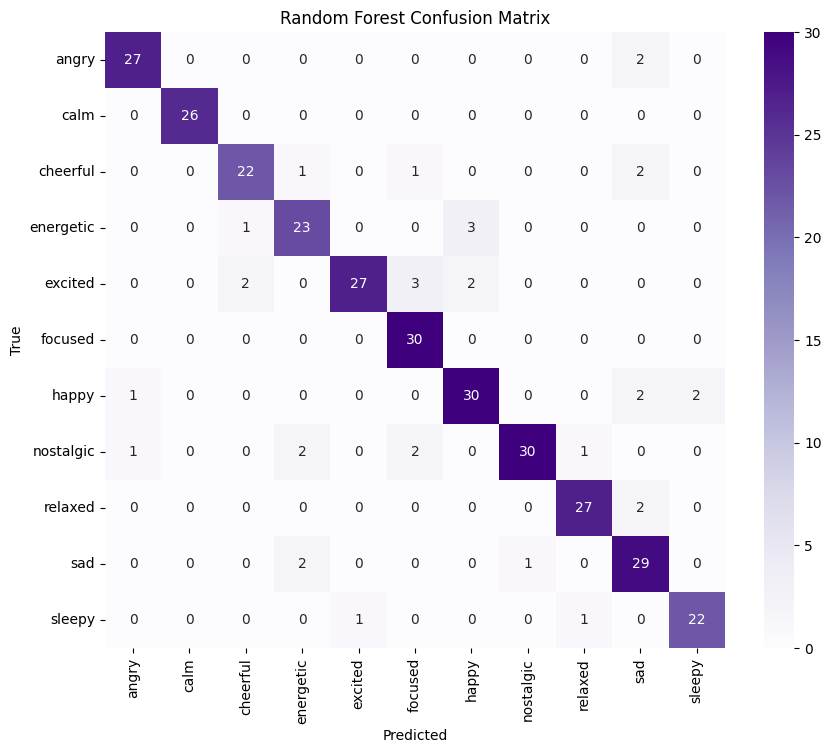

In [18]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

C:\Users\tpete\AppData\Local\Temp\ipykernel_38304\1151898954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=importances, palette="coolwarm")


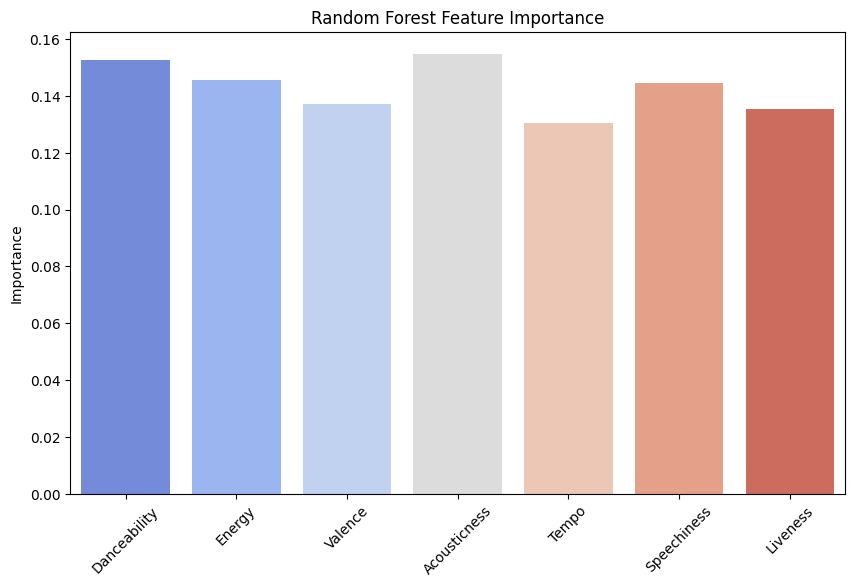

In [19]:
# Feature Importance for Random Forest - How are they doing with new emotions
importances = rf.feature_importances_
features = ['Danceability', 'Energy', 'Valence', 'Acousticness', 'Tempo', 'Speechiness', 'Liveness']
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=importances, palette="coolwarm")
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

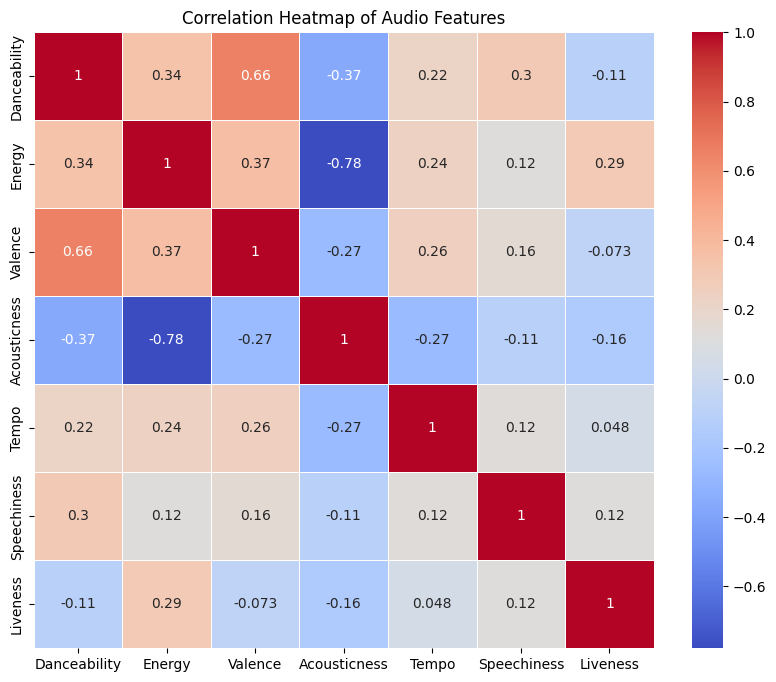

In [20]:
# Enhanced Correlation Heatmap
feature_df = pd.DataFrame(X_scaled, columns=features)
feature_df['Mood'] = y
corr_matrix = feature_df.drop(columns=['Mood']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Audio Features')
plt.show()